In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.signal import medfilt
import matplotlib.pyplot as plt

In [2]:
def plot_vertical_profiles(df, linewidth=1):
    
    fig, ax = plt.subplots(1, 1,figsize=(6,4))
    
    for flight_id, flight_df in df.groupby(level='flightId'):
        flight_states_df = df.loc[(flight_id,), :]
        
        flight_states_df =flight_states_df.sort_index(level=['sequence'], ascending = False)
        
        if not flight_states_df.empty:

            opensky_states_altitudes = flight_df['altitude'].tolist()
            opensky_states_times = flight_df.index.get_level_values('sequence').tolist()
            
            plt.plot(opensky_states_times, opensky_states_altitudes, color='k', linewidth=linewidth)

In [3]:
def plot_3_vertical_profiles(df1, df2, df3, title="", linewidth=1):
    
    fig, axs = plt.subplots(1, 3, figsize=(18,4))
    
    altitudes = df1["altitude"].values
    axs[0].set_title(title)
    axs[0].plot(range(0, len(altitudes)), altitudes)
    
    altitudes = df2["altitude"].values
    axs[1].set_title(title)
    axs[1].plot(range(0, len(altitudes)), altitudes)  
    
    altitudes = df3["altitude"].values
    axs[2].set_title(title)
    axs[2].plot(range(0, len(altitudes)), altitudes)

In [4]:
def my_altitude_fix(flight_states_df):
    
    TMA_altitude_threshold = 9000
    altitude_fluctuation_threshold_up = 300
    altitude_fluctuation_threshold_down = 600
    
    flight_states_df.reset_index(drop = False, inplace = True)
    df_len = len(flight_states_df)
            
    flight_states_df.set_index('sequence', inplace=True)
            
    if flight_states_df.empty:
        return flight_state_df
    
    opensky_states_altitudes = []
    opensky_states_times = []
    opensky_states_fixed_altitudes = []
                
    shift = 0 # shift of the wrong values
                
    prev_altitude = list(flight_states_df['altitude'])[shift]
                
    while ((prev_altitude<=0) or (prev_altitude > TMA_altitude_threshold)) and shift < df_len-1: #spike
        shift = shift + 1
        prev_altitude = list(flight_states_df['altitude'])[shift]
                
        first_good_altitude = shift
        if first_good_altitude == df_len-1:    # flight on cruise or bad data
            flight_states_df.reset_index(drop = False, inplace = True)
            flight_states_df.set_index(['flightId', 'sequence'], inplace=True)
            dropped_df = dropped_df.append(flight_states_df)
            continue
                
            while shift>0:
                shift = shift - 1
                opensky_states_fixed_altitudes.append(prev_altitude)
  
                shift = 0 # shift of the wrong values
                too_long_shift = False # if the altitudes are the same for some time (error) and then we get the right altitude but the difference is bigger than threshold
 
                for seq, row in flight_states_df.iterrows():
                    
                    if seq < first_good_altitude:
                        continue

                    opensky_states_altitudes.append(row['altitude'])
                    
                    if prev_altitude-row['altitude'] == 0:
                        shift = shift + 1
                        if shift > 10:
                            too_long_shift = True
                    else:
                        shift = 0
                        too_long_shift = False
    
                    if (row['altitude'] < prev_altitude) and ((prev_altitude-row['altitude'] > altitude_fluctuation_threshold_down) and not too_long_shift):
                        opensky_states_fixed_altitudes.append(prev_altitude)
                        continue
                   
                    if (row['altitude'] > prev_altitude) and ((row['altitude'] - prev_altitude > altitude_fluctuation_threshold_up) and not too_long_shift):
                        opensky_states_fixed_altitudes.append(prev_altitude)
                        continue
                    
                    opensky_states_fixed_altitudes.append(row['altitude'])
                    
                    prev_altitude = row['altitude']
                    
                flight_states_df["altitude"] = opensky_states_fixed_altitudes
                
            flight_states_df.reset_index(drop = False, inplace = True)
            flight_states_df.set_index(['flightId', 'sequence'], inplace=True)
    return flight_states_df

# Data uploading

In [5]:
date = 191031

In [6]:
filename = "../Data/ESSA/2019/osn_ESSA_states_50NM_2019_filtered_by_callsign/osn_arrival_ESSA_states_50NM_filtered_2019_10_week5.csv"
df = pd.read_csv(filename, sep=' ',
    names = ['flightId', 'sequence', 'timestamp', 'lat', 'lon', 'altitude', 'velocity', 'beginDate', 'endDate'])
df.set_index(['flightId', 'sequence'], inplace = True)
df = df.loc[df['endDate']==date]

In [7]:
filename = "../Data/ESSA/2019/osn_ESSA_states_50NM_2019_filtered_by_altitude/osn_arrival_ESSA_states_50NM_2019_10_week5.csv"
filtered2_df = pd.read_csv(filename, sep=' ',
    names = ['flightId', 'sequence', 'timestamp', 'lat', 'lon', 'rawAltitude', 'altitude', 'velocity', 'beginDate', 'endDate'])
filtered2_df.set_index(['flightId', 'sequence'], inplace = True)
filtered2_df = filtered2_df.loc[filtered2_df['endDate']==date]

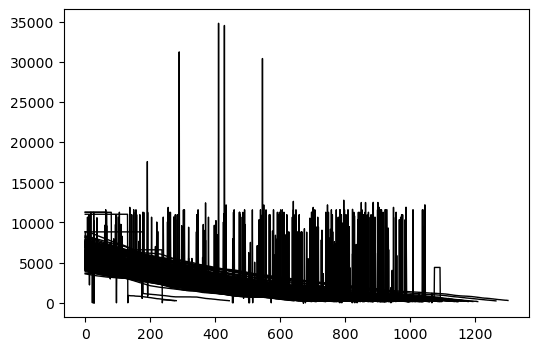

In [8]:
plot_vertical_profiles(df)

In [9]:
def compare_profiles(flight_id):
    flight_id = flight_id
    flight_df1 = df.loc[(flight_id,), :]
    flight_df2 = flight_df1.copy()
    flight_df3 = flight_df1.copy()

    flight_df2 = my_altitude_fix(flight_df2)

    altitudes = flight_df3["altitude"].values
    flight_df3['altitude'] = medfilt(altitudes,11)

    plot_3_vertical_profiles(flight_df1, flight_df2, flight_df3, flight_id)

In [10]:
#flight_id = '191031SAS1136' #example of bad download TODO: plot tracks
#flight_id = '191031SAS142'  #example of bad download 
#flight_id = '191031SAS864'  #example of bad download (last altitude too high)
#flight_id = '191031KLM23C'  #example of bad download (last altitude too high)
#flight_id = '191031SEJPX'   #example of noncommercial callsign
#flight_id = '191031NAX812'  #example of the spike at the first point
#flight_id = '191031FIN1NX'  #example of the spike at the first point
#flight_id = '191031BAW778F'
#flight_id = '191031FIN805'
#flight_id = '191031GFM1T'
#flight_id = '191031SAS142'
#flight_id = '191031SAS142'
#flight_id = '191031SAS1136'
#flight_id = '191031SAS106'

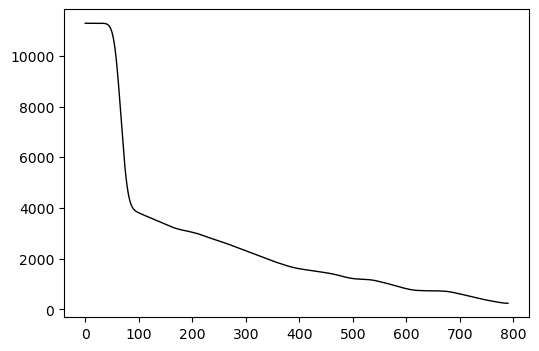

In [18]:
flight_id = "191031SAS106"
flight_df = filtered2_df[filtered2_df.index.get_level_values('flightId') == flight_id]
plot_vertical_profiles(flight_df, linewidth=1)

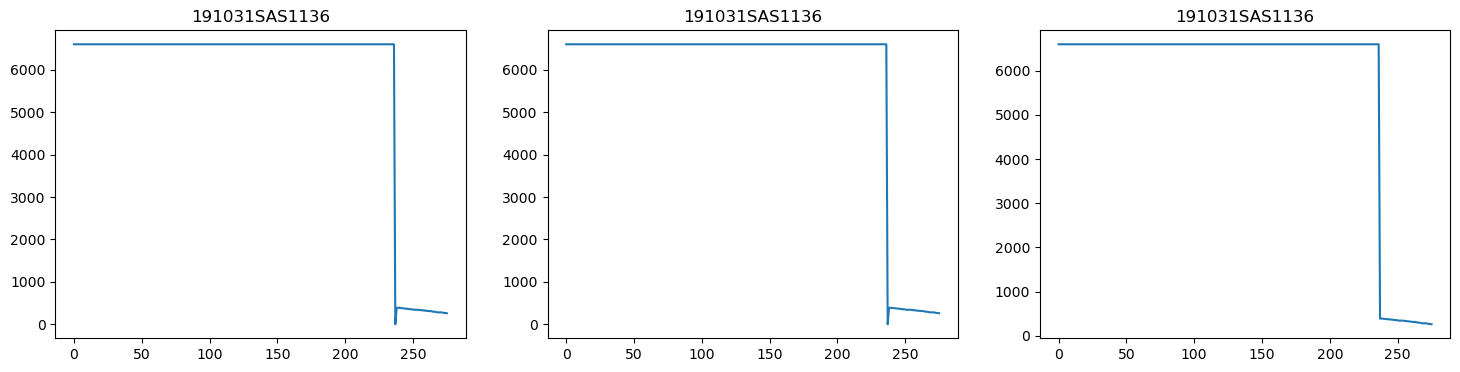

In [12]:
compare_profiles("191031SAS1136")

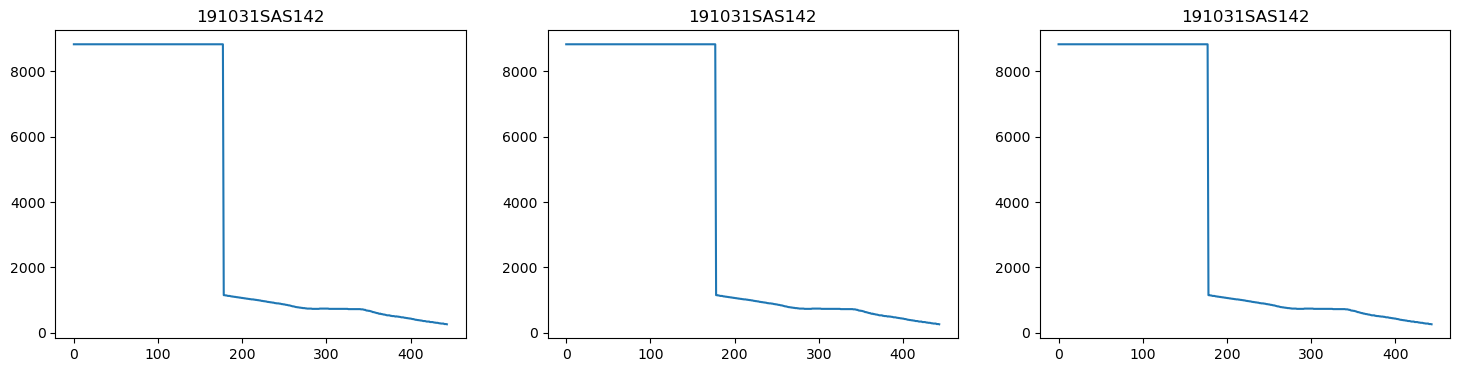

In [13]:
compare_profiles("191031SAS142")

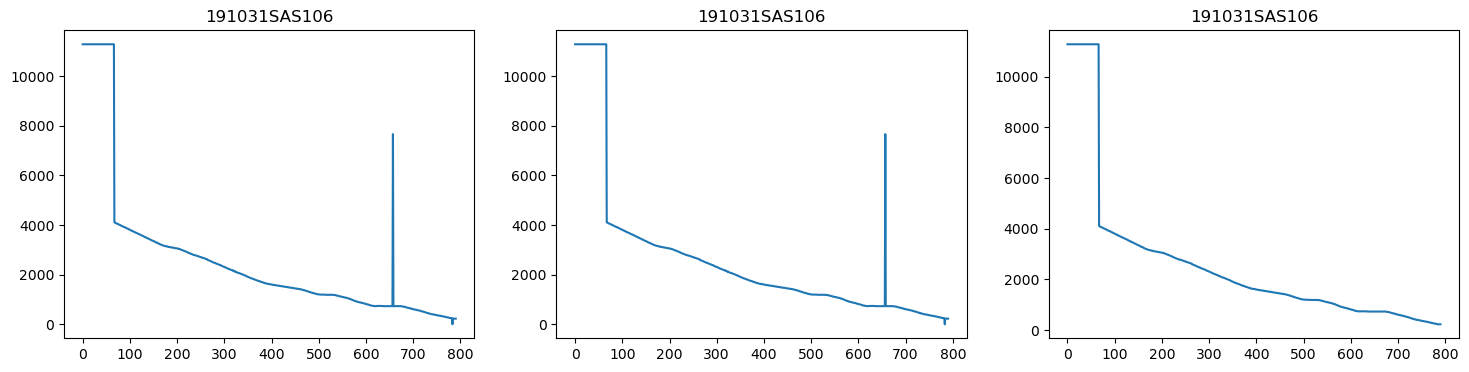

In [14]:
compare_profiles("191031SAS106")

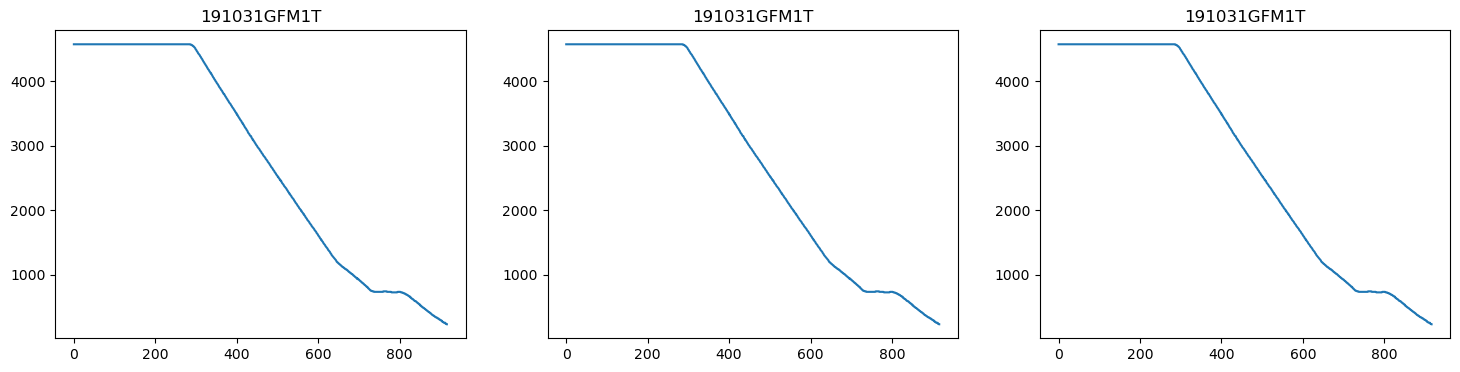

In [15]:
compare_profiles("191031GFM1T")

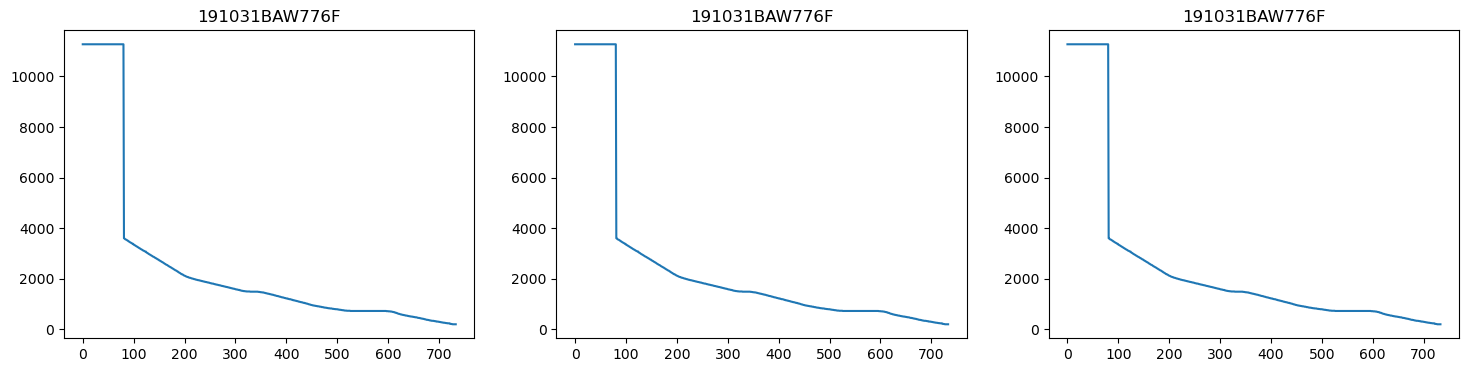

In [16]:
compare_profiles("191031BAW776F")

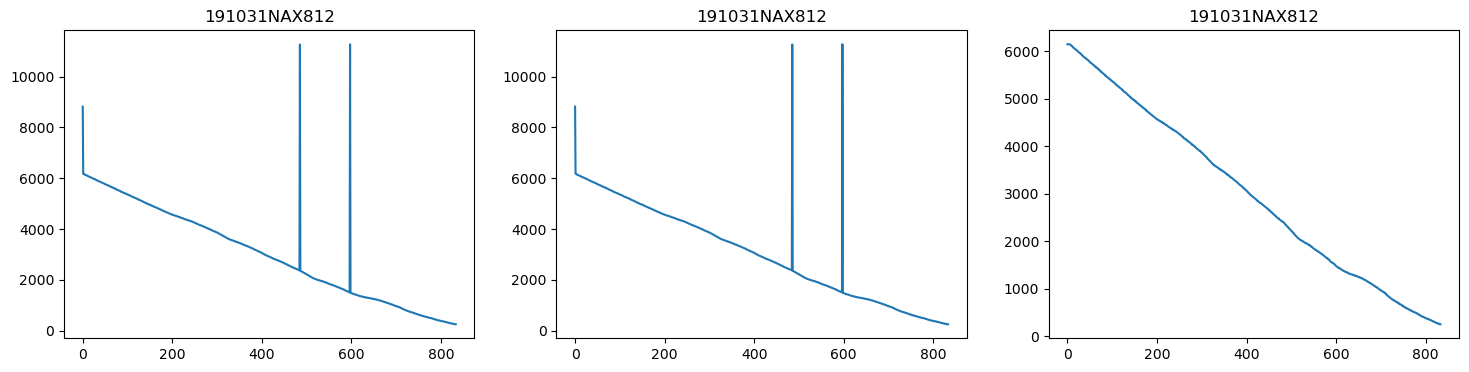

In [17]:
compare_profiles("191031NAX812")